# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import collections
from sklearn.linear_model import MultiTaskElasticNet

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# Make copies of dataframes to process data
df_az = azdias.copy()
df_info = feat_info.copy()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# How much data is missing from loaded file
df_az.isnull().sum().sum()

4896838

In [7]:
df_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# Missing values with X and XX
df_info.set_index('attribute').loc[['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']]

,information_level,type,missing_or_unknown
attribute,,,
CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [9]:
# Identify missing or unknown data values and convert them to NaNs.
# Missing values with X or XX doesn't work with ast.literal_eval, must use an except clause.
for i, row in df_info.iterrows():
        try:
            df_az[row['attribute']].replace(ast.literal_eval(row['missing_or_unknown']), np.nan, inplace=True)
        except:
            df_az[row['attribute']].replace(['-1', 'X', 'XX'], np.nan, inplace=True)

In [10]:
# How many NaN values in the dataframe after filling in for encoded missing values
df_az.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64


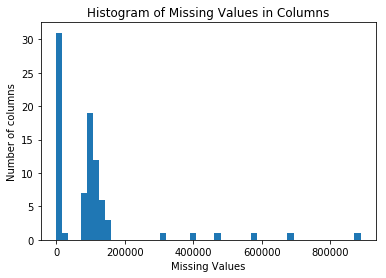

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = df_az.isnull().sum()
print(missing_data.head())

# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data, 50)
plt.xlabel('Missing Values')
plt.ylabel('Number of columns')
plt.title('Histogram of Missing Values in Columns');

In [12]:
# Lets keep columns with less than 200,000 missing values.
# Keep columns dropped in columns_to_drop
columns_to_drop = missing_data[missing_data > 200000].index.values
df_az.drop(columns_to_drop, axis=1, inplace=True)
print('Number of dropped columns: ', len(columns_to_drop))
print(columns_to_drop)

Number of dropped columns:  6
['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX']


In [13]:
# Look at columns with like numbers of missing NaNs.
# If 2 columns or more have the same number of NaNs,
# there is a high probability that the data points with NaNs
# are highly corrilated or exactly the same in those columns.
def nans_in_columns(missing_data):
    missing_data_groups = missing_data.groupby(missing_data)
    for group in missing_data_groups:
            if len(group[1]) > 1:
                print('There are {} columns with {} NaNs'.format(len(group[1]), group[0]))

nans_in_columns(df_az.isnull().sum())

There are 24 columns with 0 NaNs
There are 6 columns with 4854 NaNs
There are 4 columns with 73499 NaNs
There are 2 columns with 77792 NaNs
There are 4 columns with 93148 NaNs
There are 3 columns with 93740 NaNs
There are 2 columns with 97375 NaNs
There are 3 columns with 99352 NaNs
There are 3 columns with 111196 NaNs
There are 7 columns with 116515 NaNs
There are 6 columns with 133324 NaNs
There are 2 columns with 158064 NaNs


In [14]:
# Look more closely at the 7 columns with 116,515 NaNs in them.
# PLZ8 are macro-cell features describing house type in the region.
# If individuals live in a region without this type of information,
# large numbers of individuals will be missing values in all seven columns.
missing_data_columns = df_az.isnull().sum()
missing_data_columns = missing_data_columns[missing_data_columns == 116515]
missing_data_columns_PLZ8 = missing_data_columns.index.values
missing_data_columns_PLZ8

array(['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'], dtype=object)

In [15]:
# Look more closely at the 6 columns with 133,324 NaNs in them.
# KBA05 are micro-cell features describing house type in microcell.
# If individuals live in a micro-cell without this type of information,
# large numbers of individuals will be missing values in all 6 columns.
# Note that MOBI_REGIO (Movement patterns, regional feature) is also closely corrilated with KBA05
missing_data_columns = df_az.isnull().sum()
missing_data_columns = missing_data_columns[missing_data_columns == 133324]
missing_data_columns_KBA05 = missing_data_columns.index.values
missing_data_columns_KBA05

array(['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'MOBI_REGIO'], dtype=object)

In [16]:
# See if individuals that are missing data in the PLZ8 columns are also missing values in the
# KBA05 columns and visa versa?
s = df_az[list(missing_data_columns_PLZ8) + list(missing_data_columns_KBA05)].isnull().sum(axis=1)
groups = s.groupby(s)
print('There are 7 PLZ8 rows, 6 KBA05 rows')
for group in groups:
    print('There are {} rows missing {} many NaNs'.format(len(group[1]), group[0]))

There are 7 PLZ8 rows, 6 KBA05 rows
There are 748448 rows missing 0 many NaNs
There are 26258 rows missing 6 many NaNs
There are 9449 rows missing 7 many NaNs
There are 107066 rows missing 13 many NaNs


In [17]:
# How much of the missing data does this pattern of 13 columns with 107,066 rows of missing data explain?
print('{}% of the missing data is explained by this relationship'.format(int(round(107066 * 13 * 100/df_az.isnull().sum().sum()))))

28% of the missing data is explained by this relationship


#### Discussion 1.1.2: Assess Missing Data in Each Column

I first plotted a histogram that shows the distribution of the number of NANs in columns. It shows that a few columns have a relatively large amount of NaNs compared to the majority of columns. I dropped all columns with greater than 200K NaNs. The columns dropped are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.

I looked at columns that have the same amount of NaNs in them and see that there are quite a few of them. It seems that many columns are highly correlated with respect to having the same data points with NaNs. Looking more closely at the 7 columns with 116,515 NaNs and the 6 columns with 133,324 NaNs we come to some interesting conclusions.
1. There are 107,066 rows with NaNs in all 13 columns.
2. The first 7 columns are macro-cell features describing house types in the region (prefix 'PLZ8').
3. The second 5 columns are micro-cell features describing house type in the microcell (prefix 'KBA05'). And the last column 'MOBI_REGIO' (Movement patterns, regional feature), has the exact same rows with missing values as 'KBA05' columns.
4. 28% of the missing data is explained by not having data on housing types in particular regions and microcells.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

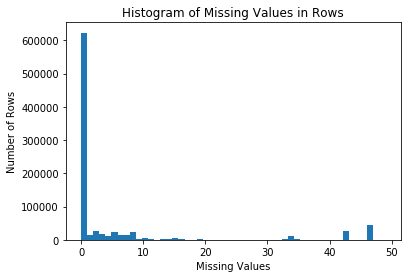

In [18]:
# How much data is missing in each row of the dataset?
missing_data_row = df_az.isnull().sum(axis=1)
plt.hist(missing_data_row, 50)
plt.xlabel('Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of Missing Values in Rows');

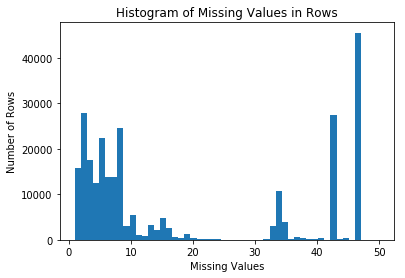

In [19]:
# Without 0
missing_data_row = df_az.isnull().sum(axis=1)
plt.hist(missing_data_row, 50, (1,50))
plt.xlabel('Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of Missing Values in Rows');

In [20]:
# Let's keep track of individuals that are missing both regional and microcell data.
# They may make a nice cluster
missing_regional_index = s[s.values == 13].index.values
len(missing_regional_index)

107066

In [21]:
# Try dropping rows with missing regional and microcell information
df_az__regional_info_False = df_az.iloc[missing_regional_index]
df_az__regional_info_True = df_az.drop(missing_regional_index, axis=0)

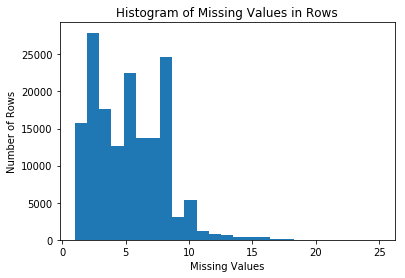

In [22]:
# Without 0
missing_data_row = df_az__regional_info_True.isnull().sum(axis=1)
plt.hist(missing_data_row, 25, (1,25))
plt.xlabel('Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of Missing Values in Rows');

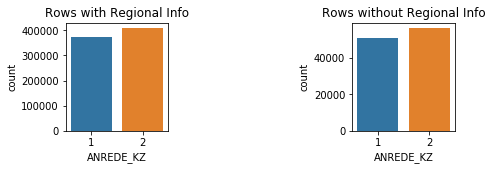

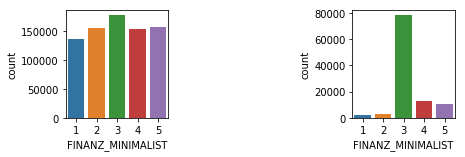

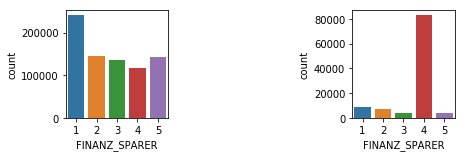

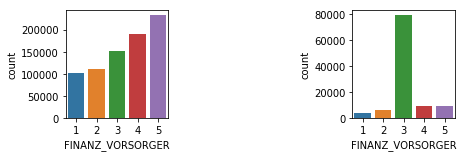

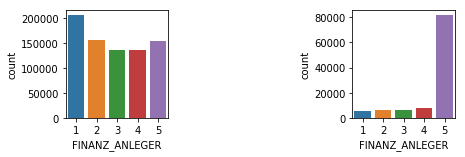

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_dist(label, low, high, column):
    plt.figure(label)
    
    plt.subplot(121)
    sns.countplot(low[column])
    if label == 0:
        plt.title('Rows with Regional Info')
    
    plt.subplot(122)
    sns.countplot(high[column])
    if label == 0:
        plt.title('Rows without Regional Info')
    
    plt.subplots_adjust(left=0.0, wspace=1.8, top=0.5)

columns = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']
for label, column in enumerate(columns):
    compare_dist(label, df_az__regional_info_True, df_az__regional_info_False, column)

In [24]:
# Drop the rows that are missing regional and micro-cell housing data from df_az
df_az = df_az.drop(missing_regional_index, axis=0)

#### Discussion 1.1.3: Assess Missing Data in Each Row
  
Looking at the histogram of missing values in rows, there are a number of rows with a large amount of missing values that are out of character from the rest of the data (>30 NaNs). In the last section, I looked at columns with very similar numbers of NaNs in them, a pattern emerged that regional and micro-cell housing information was missing, resulting in 28% of the missing data explained. I drop all rows that are missing values in all regional and micro-cell housing columns and relook at the histogram of missing values. All rows with greater than 30 NaNs are now gone and the distribution has a reasonable shape without outlayers. I then compare the distributions of values in 5 attributes to see if the dropped data is similar to the leftover data. The plots above show that in 4 out of the 5 attributes, one value is overwhelmingly favored in the dropped data compared to the undropped data. I have kept the indexes of the rows dropped in "missing_regional_index". I will continue on with the undropped rows but plan on using the dropped rows as a seperate cluster when I do my analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# Drop attributes not in df_az
df_info = df_info.loc[df_info['attribute'].isin(df_az.columns)]

In [26]:
# How many features are there of each data type?
df_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [28]:
# Look only at categorical attributes
cat_info = df_info.loc[df_info['type'] == 'categorical'].copy()

# Add column with value counts for each attribute
cat_info = cat_info.assign(value_counts=[len(df_az[attribute].value_counts()) for attribute in cat_info['attribute']])

# Look at number of attributes with x amount of categories
print('Number of categorical attributes: ', len(cat_info))
cat_info['value_counts'].value_counts()

Number of categorical attributes:  18


2     5
6     3
5     2
44    1
12    1
11    1
10    1
9     1
7     1
4     1
3     1
Name: value_counts, dtype: int64

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [30]:
# Look only at binary attributes
cat_info_2 = cat_info.loc[cat_info['value_counts'] == 2].copy()

# Find binary attribute that is not an int or float 
for attribute in cat_info_2['attribute']:
    dtype = df_az[attribute].dtype
    if dtype not in [int, float]:
        print(attribute, dtype)

OST_WEST_KZ object


In [31]:
# Change to numerical categories
df_az.loc[:, 'OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)

In [32]:
# Look at non binary categorical count values
cat_info_rest = cat_info.loc[cat_info['value_counts'] != 2].copy()

# One Hot encode the rest of the categorical attributes and drop original attributes
def one_hot_encode(df, columns):
    '''
    One hot encode columns in df and drop columns.
    columns is a list
    '''
    dfOneHot = pd.DataFrame()
    for column in columns:
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column)
        dfOneHot = pd.concat([dfOneHot, dfDummies], axis=1)
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns, axis=1, inplace=True)
    return df

to_one_hot_encode = cat_info_rest['attribute'].values
df_az = one_hot_encode(df_az, to_one_hot_encode)

df_az.shape

(784155, 194)

In [33]:
# print out attributes to one hot encode for later use in cleaning function
print(to_one_hot_encode)

['CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP' 'LP_FAMILIE_FEIN'
 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'SHOPPER_TYP' 'ZABEOTYP' 'GEBAEUDETYP' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

There are 18 categorical attributes with 5 being binary. One binary was not numerical, so I changed that to numerical. I leave the binary numerical attributes as is for analysis. If categorical attributes have more than 2 categories, it does not make sense to treat them as an interval since they don't have inherent order. For the rest of the catigorical attributes, I one hot encoded them and dropped the original attributes.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Decide what to do with mixed type features
mixed_info = df_info.loc[df_info['type'] == 'mixed'].copy()
mixed_info

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df_az['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [36]:
# Make dictionary for PRAEGENDE_JUGENDJAHRE attribute
# key: (decade, movement)
pj_dict = {1.0: (1, 1), 2.0: (1, 2), 3.0: (2, 1),
           4.0: (2, 2), 5.0: (3, 1), 6.0: (3, 2),
           7.0: (3, 2), 8.0: (4, 1), 9.0: (4, 2),
           10.0: (5, 1), 11.0: (5, 2), 12.0: (5, 1),
           13.0: (5, 2), 14.0: (6, 1), 15.0: (6, 2)}

# Add columns for 2 new attributes and drop PRAEGENDE_JUGENDJAHRE
def pj_funct(x, pj_dict, index):
    if pd.isnull(x):
        return x
    else:
        return pj_dict[x][index]
        
df_az['PRAEGENDE_JUGENDJAHRE_decade'] = df_az['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pj_funct(x, pj_dict, 0))
df_az['PRAEGENDE_JUGENDJAHRE_movement'] = df_az['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pj_funct(x, pj_dict, 1))
df_az.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_az['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [38]:
# Add columns for 2 new attributes and drop CAMEO_INTL_2015
def ci_funct(x, index):
    if pd.isnull(x):
        return x
    else:
        return int(x[index])

df_az['CAMEO_INTL_2015_wealth'] = df_az['CAMEO_INTL_2015'].apply(lambda x: ci_funct(x, 0))
df_az['CAMEO_INTL_2015_lifestage'] = df_az['CAMEO_INTL_2015'].apply(lambda x: ci_funct(x, 1))
df_az.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [39]:
# Drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, PLZ8_BAUMAX due to a complicated entaglement of dimensions
df_az.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 attributes that are mixed. Each attribute had seperate issues so I will go through them one by one. 
1. "PRAEGENDE_JUGENDJAHRE" : Had 3 dimensions in one (decade, movement, nation). The nation dimension had a complicated entanglement so I ignored it. I put each remaining dimension in a seperate attribute. "decade" is ordinal so I left it as is. "movement" is categorical binary so I left it as is. I dropped the original.
2. "CAMEO_INTL_2015" : Had 2 dimensions that were both ordinal (Wealth and Life Stage) so I added 2 attributes and dropped the original.
3. "LP_LEBENSPHASE_FEIN" : Dropped due to complicated entaglement of the dimensions (Life stage and income level, fine scale)
4. "LP_LEBENSPHASE_GROB" : Dropped due to complicated entaglement of the dimensions (Life stage and income level, rough scale)
5. "WOHNLAGE" : Had 2 dimensions (Neighborhood quality and rural flag) that were hard to untagle, so dropped it.
6. "PLZ8_BAUMAX" : Has 2 dimensions (building type family and Business) that are hard to untangle, so dropped it.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [119]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Make sure all attributes are ints or floats 
for attribute in df_az.columns.values:
    dtype = df_az[attribute].dtype
    if dtype not in [int, float, np.uint8]:
        print(attribute, dtype)

df_az.shape

(784155, 193)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
# Functions needed in clean_data function

# Note the one_hot_encoding requires a dictionary from the 
# General df to encode the categories for the Customer df.
# If this is not done the categories do not line up, 
# i.e. the Customer df will have less columns than the General df.
def one_hot_encode(df, columns, categories = None):
    '''
    Return one hot encode columns in df.
    If General dataframe, return categories dictionary to use with Customers dataframe.
    If Customers dataframe, use categories made by the General dataframe to one hot encode columns.
    
    INPUT: df:
           columns: list
           categories: dictionary with training columns as keys and
                       list of training categories as values.
                       Or None to make the dictionary.
    OUTPUT: df: one hot encoded columns and drop orginal columns
            categories: dictionary with training columns as keys and
                        list of training categories as values.
    '''
    dfOneHot = pd.DataFrame()
    if categories:
        for column in columns:
            df[column] = pd.Categorical(df[column], categories=categories[column])
            dfDummies = pd.get_dummies(df[column], prefix = column)
            dfOneHot = pd.concat([dfOneHot, dfDummies], axis=1)
    else:
        categories = dict()
        for column in columns:
            df[column] = pd.Categorical(df[column])
            categories[column] = df[column].cat.categories
            dfDummies = pd.get_dummies(df[column], prefix = column)
            dfOneHot = pd.concat([dfOneHot, dfDummies], axis=1)
    df = pd.concat([df, dfOneHot], axis=1)
    df.drop(columns, axis=1, inplace=True)
    return df, categories

def pj_funct(x, pj_dict, index):
    '''
    Function used for 'PRAEGENDE_JUGENDJAHRE' attribute
    '''
    if pd.isnull(x):
        return x
    else:
        return pj_dict[x][index]
    
def ci_funct(x, index):
    '''
    Function used for 'CAMEO_INTL_2015' attribute
    '''
    if pd.isnull(x):
        return x
    else:
        return int(x[index])
    
def clean_data(df, df_info, categories=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: df to be cleaned, info df, and 
           categories dictionary if cleaning customer df. 
    OUTPUT: Cleaned df, categories dictionary
    """

    # Identify missing or unknown data values and convert them to NaNs.
    for i, row in df_info.iterrows():
            try:
                df[row['attribute']].replace(ast.literal_eval(row['missing_or_unknown']), np.nan, inplace=True)
            except:
                df[row['attribute']].replace(['-1', 'X', 'XX'], np.nan, inplace=True)
    
    
    
    # Drop rows if they are missing on regional and micro-cell house type info
    # Save to use for future analysis
    regional_micro_columns = ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'MOBI_REGIO', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
    s = df[regional_micro_columns].isnull().sum(axis=1)
    rows_to_drop = s[s.values == 13].index.values
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Columns to drop based on a threshold of 200000 NaN values in general population df.
    # Include columns 'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' due to a complicated entaglement of dimensions
    columns_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'WOHNLAGE']
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    # Change 'OST_WEST_KZ' from string binary categories to numeric 
    df.loc[:, 'OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)
    
    # One hot encode non binary categorical columns
    to_one_hot_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
                         'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                         'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
                         'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df, categories = one_hot_encode(df, to_one_hot_encode, categories)
    
    # Make new attributes for 'PRAEGENDE_JUGENDJAHRE' and drop original
    pj_dict = {1.0: (1, 1), 2.0: (1, 2), 3.0: (2, 1),
               4.0: (2, 2), 5.0: (3, 1), 6.0: (3, 2),
               7.0: (3, 2), 8.0: (4, 1), 9.0: (4, 2),
               10.0: (5, 1), 11.0: (5, 2), 12.0: (5, 1),
               13.0: (5, 2), 14.0: (6, 1), 15.0: (6, 2)}
    
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pj_funct(x, pj_dict, 0))
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pj_funct(x, pj_dict, 1))
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Make new attributes for 'CAMEO_INTL_2015' and drop original
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: ci_funct(x, 0))
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(lambda x: ci_funct(x, 1))
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    return df, categories, rows_to_drop

In [41]:
df_clean, categories, df_rows_to_drop = clean_data(azdias.copy(), feat_info.copy())

In [42]:
df_clean.shape

(784155, 192)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [120]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [43]:
# Many missing values
df_clean.isnull().sum().sum()

564790

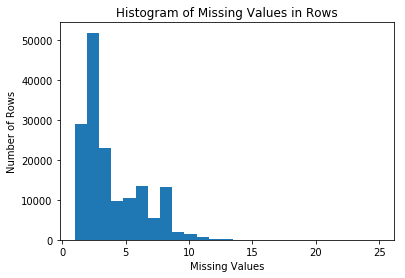

In [44]:
# Without 0
missing_data_row = df_clean.isnull().sum(axis=1)
plt.hist(missing_data_row, 25, (1,25))
plt.xlabel('Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of Missing Values in Rows');

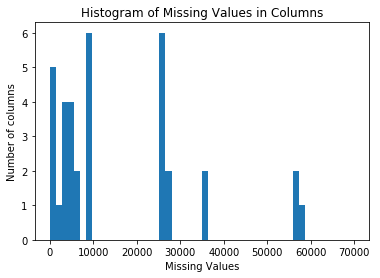

In [45]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_column = df_clean.isnull().sum()

# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data_column, 50, (1,70000))
plt.xlabel('Missing Values')
plt.ylabel('Number of columns')
plt.title('Histogram of Missing Values in Columns');

In [46]:
# Find columns names with missing values
columns_NaN = missing_data_column[missing_data_column != 0].index.values
columns_noNaN = missing_data_column[missing_data_column == 0].index.values

In [47]:
# Print columns with missing values and the maximum corrilation with 
# columns with no missing values
for i, column in enumerate(columns_NaN):
    if i < 9:
        s = df_clean[columns_noNaN].apply(lambda x: x.corr(df_clean[column]))
        print(column, max(abs(s.values).tolist()))

ALTERSKATEGORIE_GROB 0.7654464651156747
HEALTH_TYP 0.24106325590057534
RETOURTYP_BK_S 0.43289781618410045
VERS_TYP 0.24000780538003474
W_KEIT_KIND_HH 0.5159954283020836
ANZ_HAUSHALTE_AKTIV 0.3571503685552714
ANZ_HH_TITEL 0.22754267871826003
KONSUMNAEHE 0.3453292248783368
KBA05_ANTG1 0.6082784423479923


## Replace missing values
Many of the columns with missing data are strongly correlated with columns with no missing data. Replace missing values with a regression found from columns with no missing values. Worse case scenerio is you get the mean if they aren't correlated.
Steps taken:
1. Scale all columns with no missing value rows.
2. Train regressors for each column that is missing data.
3. Use regressors to find values for missing values in missing value data set.

In [49]:
def impute_general(df):
    # Find rows and columns with missing data
    missing_data_row = df.isnull().sum(axis=1)
    missing_data_column = df.isnull().sum()
    
    # Find columns names with missing values
    columns_NaN = missing_data_column[missing_data_column != 0].index.values
    columns_noNaN = missing_data_column[missing_data_column == 0].index.values
    
    # Find row indexs with missing values
    noNaN_index = missing_data_row[missing_data_row == 0].index
    NaN_index = missing_data_row[missing_data_row != 0].index
    
    # Split into 4 based on NaNs in columns and rows.
    df_noNaN_col_NaN_row = df.loc[NaN_index, columns_noNaN]
    df_noNaN_col_noNaN_row = df.loc[noNaN_index, columns_noNaN]
    df_NaN_col_NaN_row = df.loc[NaN_index, columns_NaN]
    df_NaN_col_noNaN_row = df.loc[noNaN_index, columns_NaN]
    
    # Fit and transform on columns with no NaNs and rows with no NaNs.
    # Transform on columns with no NaNs and rows with NaNs.
    # Don't scale the columns with NaNs.
    scaler_NaN = StandardScaler()
    X_train = scaler_NaN.fit_transform(df_noNaN_col_noNaN_row) # scaled_noNaN_col_noNaN_row
    X_test = scaler_NaN.transform(df_noNaN_col_NaN_row) # scaled_noNaN_col_NaN_row
    Y_train = df_NaN_col_noNaN_row.values # No need to scale
    
    # Fit Regressor to with training data
    regressor = MultiTaskElasticNet()
    regressor.fit(X_train, Y_train)
    
    # Predict all values in the df with columns with NaNs and rows with NaNs
    Y_test = regressor.predict(X_test)
    df_Y_test = pd.DataFrame(Y_test, index = df_NaN_col_NaN_row.index, columns = df_NaN_col_NaN_row.columns)
    
    # Make sure the values are within the attribute possible values
    min_max_values = ((1,4),(1,3),(1,5),(1,2),(1,6),(0,1000),(0, 10000),(1,7),(0,4),(0,4),(0,3),
                     (0,3),(1,5),(1,7),(1,6),(1,8),(1,5),(1,4),(1,5),(1,5),(1,7),(0,1000000),(0,4),
                     (0,4),(0,3),(0,2),(1,5),(1,5),(1,5),(1,5),(1,9),(1,5),(1,6),(1,2),(1,5),(1,5))

    max_min_columns = zip(columns_NaN, min_max_values)
    for column in max_min_columns:
        df_Y_test[column[0]] = df_Y_test[column[0]].clip(lower=column[1][0], upper=column[1][1])

    # Fill in NaNs with df_Y_test values
    df_NaN_col_NaN_row.fillna(df_Y_test, inplace=True)
    
    # Remake df with no NaNs
    df_noNaN = pd.concat([pd.concat([df_noNaN_col_NaN_row, df_NaN_col_NaN_row], axis=1),
                               pd.concat([df_noNaN_col_noNaN_row, df_NaN_col_noNaN_row], axis=1)], axis=0)
    df_noNaN = df_noNaN[df.columns].sort_index()
    
    return df_noNaN, columns_NaN, scaler_NaN, regressor

In [50]:
df_general_noNaN, columns_NaN, scaler_NaN, regressor_NaN = impute_general(df_clean)

In [51]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled = scaler.fit_transform(df_general_noNaN)

### Discussion 2.1: Apply Feature Scaling

I found columns with missing values and calculated the correlation of these columns with columns that have no missing values. I then printed the missing value columns out with the biggest correlation score. Since many of the columns are correlated fairly well with columns that have no missing values, I decided to use a regressor to fill in NaN values. The impute_general function takes a dataframe with missing values and uses the MultiTaskElasticNet class to fill in the NaN values. I return a dataframe with no missing values, along with a list of columns (that have NaN values) and  the scaler and regressor used. These will be used later on when I impute the customer data. 

I felt this method is better that filling with a mean value due to the highly correlated attributes. If there is not much correlation, the regressor fills the value with something close to the mean. Since at the end of the day we are after clusters that capture trends in the data, I felt like a regression would help accentuate clusters verses filling with a mean value. A mean value would have the effect of homogenizing the data. Dropping the rows with NaN values would also work but I decided against this due to the loss of information.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

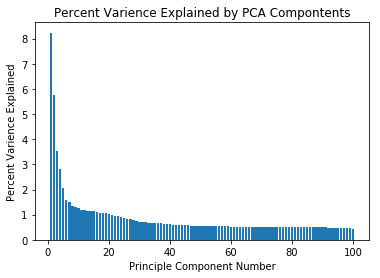

In [30]:
# Apply PCA to the data.
pca = PCA(n_components=100)
pca.fit(scaled)

# Investigate the variance accounted for by each principal component.
var_ratio = pca.explained_variance_ratio_
plt.bar(range(1, len(var_ratio) + 1), var_ratio * 100, align='center')
plt.xlabel('Principle Component Number')
plt.ylabel('Percent Varience Explained')
plt.title('Percent Varience Explained by PCA Compontents');

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=5)
pca.fit(scaled)

print('The first five principle components account for {}% of the total variance'.format(
    int(round(pca.explained_variance_ratio_.sum() * 100))))

The first five principle components account for 22% of the total variance


### Discussion 2.2: Perform Dimensionality Reduction

Looking at the Percent Varience Explained by the first 100 PCA components, I chose to keep the first five components because each explains a significant amount more of the varience than the following component. After five, the components seem to level off. The first five components explain 23% of the varience.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Function to keep the first and last 2 attributes in the sorted list
# of weighted attributes of the ith principle component.
def component_sort(components, keys, i):
    assert(len(components) > i and 0 <= i)
    component = components[i]
    name_weight = list(zip(keys, component))
    name_weight.sort(key=lambda tup: tup[1],reverse=True)
    keep = name_weight[:2] + name_weight[-2:]
    return keep

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
component_sort(pca.components_, df_clean.keys(), 0)

[('LP_STATUS_GROB_1.0', 0.19553257499030591),
 ('HH_EINKOMMEN_SCORE', 0.1865301594468996),
 ('KBA05_ANTG1', -0.19544817733998701),
 ('MOBI_REGIO', -0.20854374985537871)]

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_sort(pca.components_, df_clean.keys(), 1)

[('ALTERSKATEGORIE_GROB', 0.23321464185666957),
 ('FINANZ_VORSORGER', 0.21920720401450633),
 ('FINANZ_SPARER', -0.22722744477757711),
 ('PRAEGENDE_JUGENDJAHRE_decade', -0.24191905879985545)]

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_sort(pca.components_, df_clean.keys(), 2)

[('SEMIO_VERT', 0.31923818610356125),
 ('SEMIO_FAM', 0.26031546278721818),
 ('SEMIO_KAEM', -0.31513598334403031),
 ('ANREDE_KZ', -0.34497571182987957)]

### Discussion 2.3: Interpret Principal Components

I printed out the strongest weighted attributes for the first 3 principle components. I will go through each component:
1. 'MOBI_REGIO' = Regional Movement patterns (1-very high, 6-none)  
'LP_STATUS_GROB_1.0' = Social status (0-all other earners, 1-low inclome earner)
  * As the value of principle component (pc1) goes up, the regional movement patterns become higher and   
   social status goes towards low income earner  


2. 'PRAEGENDE_JUGENDJAHRE_decade' = Decade that individual grew up in (1-40s, 6-90s)  
'ALTERSKATEGORIE_GROB' = age (1-young, 4-old)  
'FINANZ_SPARER' = money saver (1-high, 5-low)
  * As value of pc2 goes up, individual gets older and saves more  
  

3. 'ANREDE_KZ' = gender (1-male, 2-female)  
'SEMIO_VERT' = dreamful (1-highest, 7-lowest)
  * As value of pc3 goes up, individual is more likely to be male and less likely to be dreamful

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [31]:
# Plot negative of scores over a number of cluster sizes 
def plot_score(df, pca_model, max_clusters):
    scores = []
    transformed = pca_model.transform(df)
    for n in range(2, max_clusters):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(transformed)
        scores.append(-kmeans.score(transformed)/len(df))
    plt.plot(range(2, max_clusters), scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Negative of Score')
    plt.title('Score vs Number of Clusters');

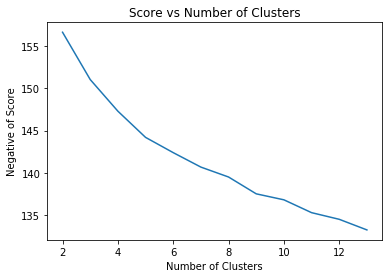

In [32]:
plot_score(scaled, pca, 14)

In [57]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=5, random_state=42).fit(pca.transform(scaled))
general_labels = kmeans.labels_


### Discussion 3.1: Apply Clustering to General Population

The average distance (proportional to negative of the score) decreases as the number of clusters increases. We can see that there are a couple elbows at 3 and 5 clusters, where before the elbows the distance is dropping at a much higher rate than after. I chose to use 5 clusters for this analysis to try and get a more precise idea of how the customer population compares to the general population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
def impute_customer(df, columns_NaN, scaler_NaN, regressor):
    missing_data_row = df.isnull().sum(axis=1)
    
    # Find columns names with no missing values
    columns_noNaN = df.drop(columns_NaN, axis=1).columns
    
    # Find row indexs with missing values
    noNaN_index = missing_data_row[missing_data_row == 0].index
    NaN_index = missing_data_row[missing_data_row != 0].index
    
    # Split into 4
    df_noNaN_col_NaN_row = df.loc[NaN_index, columns_noNaN]
    df_noNaN_col_noNaN_row = df.loc[noNaN_index, columns_noNaN]
    df_NaN_col_NaN_row = df.loc[NaN_index, columns_NaN]
    df_NaN_col_noNaN_row = df.loc[noNaN_index, columns_NaN]
    
    # Get scaled X array
    X_test = scaler_NaN.transform(df_noNaN_col_NaN_row) # scaled_noNaN_col_NaN_row
    
    # Predict
    Y_test = regressor.predict(X_test)
    df_Y_test = pd.DataFrame(Y_test, index = df_NaN_col_NaN_row.index, columns = df_NaN_col_NaN_row.columns)
    
    # Make sure the values are within the attribute possible values
    min_max_values = ((1,4),(1,3),(1,5),(1,2),(1,6),(0,1000),(0, 10000),(1,7),(0,4),(0,4),(0,3),
                     (0,3),(1,5),(1,7),(1,6),(1,8),(1,5),(1,4),(1,5),(1,5),(1,7),(0,1000000),(0,4),
                     (0,4),(0,3),(0,2),(1,5),(1,5),(1,5),(1,5),(1,9),(1,5),(1,6),(1,2),(1,5),(1,5))

    max_min_columns = zip(columns_NaN, min_max_values)
    for column in max_min_columns:
        df_Y_test[column[0]] = df_Y_test[column[0]].clip(lower=column[1][0], upper=column[1][1])
    
    # Fill in NaNs with df_Y_test values
    df_NaN_col_NaN_row.fillna(df_Y_test, inplace=True)
    
    # Remake df with no NaNs
    df_noNaN = pd.concat([pd.concat([df_noNaN_col_NaN_row, df_NaN_col_NaN_row], axis=1),
                               pd.concat([df_noNaN_col_noNaN_row, df_NaN_col_noNaN_row], axis=1)], axis=0)
    df_noNaN = df_noNaN[df.columns].sort_index()
    
    return df_noNaN

In [59]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, _, customer_rows_to_drop = clean_data(customers.copy(), feat_info.copy(), categories=categories)

customers_noNaN = impute_customer(customers_clean, columns_NaN, scaler_NaN, regressor_NaN)

customers_noNaN_scaled = scaler.transform(customers_noNaN)
customers_noNaN_pca = pca.transform(customers_noNaN_scaled)
customers_noNaN_labels = kmeans.predict(customers_noNaN_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Cluster 0 has 16% of the general population
Cluster 1 has 22% of the general population
Cluster 2 has 14% of the general population
Cluster 3 has 18% of the general population
Cluster 4 has 19% of the general population
Cluster 5 has 12% of the general population


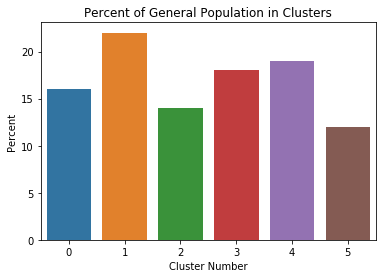

In [72]:
# General Population
counts = collections.Counter(kmeans.labels_)

# Append the number of rows that we dropped in the cleaning phase.
counts[5] = len(azdias) - len(kmeans.labels_)
percents = []
for i in range(6):
    percent = round(counts[i]*100/len(azdias))
    percents.append(percent)
    print('Cluster {} has {}% of the general population'.format(i, percent))

# Distribution of clusters for general population
sns.barplot(x = list(range(6)), y = percents);
plt.xlabel('Cluster Number')
plt.ylabel('Percent')
plt.title('Percent of General Population in Clusters');

Cluster 0 has 3% of the customer population
Cluster 1 has 15% of the customer population
Cluster 2 has 35% of the customer population
Cluster 3 has 19% of the customer population
Cluster 4 has 2% of the customer population
Cluster 5 has 27% of the customer population


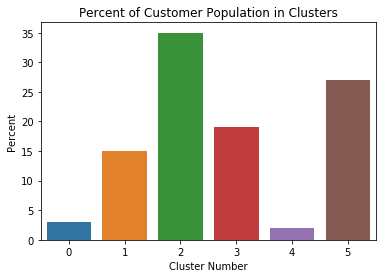

In [73]:
# Customer Population
counts = collections.Counter(customers_noNaN_labels)

# Append the number of rows that we dropped in the cleaning phase.
counts[5] = len(customers) - len(customers_noNaN_labels)
percents = []
for i in range(6):
    percent = round(counts[i]*100/len(customers))
    percents.append(percent)
    print('Cluster {} has {}% of the customer population'.format(i, percent))

# Distribution of clusters for general population
sns.barplot(x = list(range(6)), y = percents);
plt.xlabel('Cluster Number')
plt.ylabel('Percent')
plt.title('Percent of Customer Population in Clusters');

In [62]:
# Find cluster centers in original attribute space
df_centroid_clean = pd.DataFrame(np.round(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), 1),
                           columns = df_general_noNaN.keys()) 

In [64]:
# Find values of top 2 attributes (in principle component 0) for cluster centers

# Find the top 2 attributes that contribute to component i
def component_sort(components, keys, i):
    assert(len(components) > i and 0 <= i)
    component = components[i]
    name_weight = list(zip(keys, component))
    name_weight.sort(key=lambda tup: abs(tup[1]),reverse=True)
    return name_weight[:2]

pca_compontent_0 = component_sort(pca.components_, df_general_noNaN.keys(), 0)

# Top attributes for first principle component
df_centroid_clean[np.array(pca_compontent_0)[:, 0]]

,MOBI_REGIO,LP_STATUS_GROB_1.0
0,3.9,0.2
1,1.9,0.7
2,4.2,-0.0
3,4.0,0.1
4,1.8,0.8


In [66]:
# Manually make previous dataframe into english using Data_Dictionary.md 

df_centroid_eng_0 = pd.DataFrame([['low', 'higher'], ['high', 'low'], ['low', 'higher'],
                                  ['low', 'higher'], ['high', 'low']],
                                 index= ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'],
                                 columns= ['Movement patterns in region', 'Social status'])
df_centroid_eng_0

,Movement patterns in region,Social status
cluster_0,low,higher
cluster_1,high,low
cluster_2,low,higher
cluster_3,low,higher
cluster_4,high,low


In [65]:
# Find values of top 2 attributes (in principle component 0) for cluster centers

# Use 3rd best attribute because second is too close to the first (decades growing up vs age)
def component_sort(components, keys, i):
    assert(len(components) > i and 0 <= i)
    component = components[i]
    name_weight = list(zip(keys, component))
    name_weight.sort(key=lambda tup: abs(tup[1]),reverse=True)
    return [name_weight[0], name_weight[2]]

pca_compontent_1 = component_sort(pca.components_, df_general_noNaN.keys(), 1)

# Top attributes for second principle component
df_centroid_clean[np.array(pca_compontent_1)[:, 0]]

,PRAEGENDE_JUGENDJAHRE_decade,FINANZ_SPARER
0,5.7,3.9
1,3.3,1.9
2,3.7,1.7
3,3.5,1.7
4,5.7,4.3


In [67]:
# Manually make previous dataframe into english using Data_Dictionary.md 

df_centroid_eng_1 = pd.DataFrame([['upper 80s', 'low'], ['mid 60s', 'high'], ['upper 60s', 'high'],
                                  ['mid 60s', 'high'], ['upper 80s', 'low']],
                                 index= ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'],
                                 columns= ['Decade of youth', 'money-saver'])
df_centroid_eng_1

,Decade of youth,money-saver
cluster_0,upper 80s,low
cluster_1,mid 60s,high
cluster_2,upper 60s,high
cluster_3,mid 60s,high
cluster_4,upper 80s,low


In [68]:
# Combine
df_centroid_eng = df_centroid_eng_0.merge(df_centroid_eng_1, left_index=True, right_index=True)
df_centroid_eng

,Movement patterns in region,Social status,Decade of youth,money-saver
cluster_0,low,higher,upper 80s,low
cluster_1,high,low,mid 60s,high
cluster_2,low,higher,upper 60s,high
cluster_3,low,higher,mid 60s,high
cluster_4,high,low,upper 80s,low


In [69]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_centroid_eng.loc['cluster_2']

Movement patterns in region          low
Social status                     higher
Decade of youth                upper 60s
money-saver                         high
Name: cluster_2, dtype: object

In [70]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df_centroid_eng.loc['cluster_4']

Movement patterns in region         high
Social status                        low
Decade of youth                upper 80s
money-saver                          low
Name: cluster_4, dtype: object

### Discussion 3.3: Compare Customer Data to Demographics Data

I made two bar charts corrisponding to the general population and customer population. Each bar chart has clusters on the x-axis and percent of population on the y-axis. The cluster that increases the most from the general population to cluster population is cluster_2. The cluster that decreases the most is cluster_4.

To get a sense of what type of person belongs to cluster_2 and cluster_4, I found the values of the cluster center for the attributes that have the most varience within the first 2 principle components. The 4 attributes with the most varience are:

1. MOBI_REGIO = Movement patterns in region
2. LP_STATUS_GROB_1.0 = Social Status
3. PRAEGENDE_JUGENDJAHRE_decade = Decade of youth
4. FINANZ_SPARER = Money-Savor

The values of the cluster center in these 4 attributes paints a picture of what type of person is most likely to be a customer of the mail order company along with what type of person is least likely to be a customer.

1. Customers tend to live in a region that has low movement patterns, a higher social status (make more money), grew up in the 60s and save money.
2. Individuals not likely to be customers tend to live in a region that has high movement patterns, are of a lower social status, grew up in the 80s and don't save money.

One final note, cluster_5 is made up of people we dropped because they had missing regional and micro-cell data. This cluster went from 12% of the general population to 27% of the customer population. Missing regional and micro-cell data does seem to happen more often in the customer population as compared to the general population. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.